# Test the accuracy against BLAST on CataloDB

Here we have a low sequence homology set so we can really test how the model performs on low homology sequences.

The first step is to get the residues and test the two sets.



In [30]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.save_step import Save
from sciutil import SciUtil
from Bio import SeqIO


u = SciUtil()

swissprot = pd.read_csv('data/wills_metadata.tsv', sep='\t')
swissprot = pd.read_csv('data/reviewed_sprot_08042025.tsv', sep='\t')

def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/Low30_mmseq_ID_exp_subset_train.csv')['Entry'].values)
test_ids = set(pd.read_csv('data/Low30_mmseq_ID_exp_subset_test_foldseek.csv')['Entry'].values)

u.dp(['Number of training set:', len(training_ids), '\nNumber of test set:', len(test_ids)])

# Filter to not include the ones that weren't in the test set
# Read in the fasta files
# Read a FASTA file
test_ids = []
for record in SeqIO.parse("data/fastas/test.fasta", "fasta"):
    test_ids.append(record.id.split('|')[1])

# After filtering for those in SwissProt
test_df = swissprot[swissprot['Entry'].isin(test_ids)]
training_df = swissprot[swissprot['Entry'].isin(training_ids)]

u.dp(['Number of training set:', len(training_df), '\nNumber of test set:', len(test_df)])

--------------------------------------------------------------------------------
             Number of training set:	5355	
Number of test set:	239	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
             Number of training set:	5355	
Number of test set:	232	             
--------------------------------------------------------------------------------


In [2]:
# Save the training data as a database we're going to save this as a fasta file 
fasta_label = f'cataloDB_test.fasta'
with open(fasta_label, 'w+') as fout:
    for entry, seq in test_df[['Entry', 'Sequence']].values:
        if entry in test_ids:
            fout.write(f'>{entry}\n{seq}\n')
        else:
            # Just making double sure no contamination
            print(f"{entry} in training set?")

In [4]:

os.system(f'squidly {fasta_label} esm2_t48_15B_UR50D data/ CataloDB_15B --as-threshold 0.97 --lstm-model-as CataloDB_final_models/Squidly_LSTM_15B.pth --cr-model-as CataloDB_final_models/Squidly_CL_15B.pt')


--------------------------------------------------------------------------------
                             Starting squidly... 	                              
--------------------------------------------------------------------------------


100%|██████████| 232/232 [00:00<00:00, 159494.92it/s]


--------------------------------------------------------------------------------
Running with user supplied squidly models:  	CataloDB_final_models/Squidly_CL_15B.pt	CataloDB_final_models/Squidly_LSTM_15B.pth	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Running command:	python /disk1/ariane/miniconda3/envs/squidly/lib/python3.10/site-packages/squidly/squidly.py cataloDB_test.fasta esm2_t48_15B_UR50D CataloDB_final_models/Squidly_CL_15B.pt CataloDB_final_models/Squidly_LSTM_15B.pth data/ --toks_per_batch 5 --AS_threshold 0.97	
--------------------------------------------------------------------------------


0

In [5]:

os.system(f'squidly {fasta_label} esm2_t36_3B_UR50D data/ CataloDB_3B --as-threshold 0.97 --lstm-model-as CataloDB_final_models/Squidly_LSTM_3B.pth --cr-model-as CataloDB_final_models/Squidly_CL_3B.pt')


--------------------------------------------------------------------------------
                             Starting squidly... 	                              
--------------------------------------------------------------------------------


100%|██████████| 232/232 [00:00<00:00, 113280.39it/s]


--------------------------------------------------------------------------------
Running with user supplied squidly models:  	CataloDB_final_models/Squidly_CL_3B.pt	CataloDB_final_models/Squidly_LSTM_3B.pth	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Running command:	python /disk1/ariane/miniconda3/envs/squidly/lib/python3.10/site-packages/squidly/squidly.py cataloDB_test.fasta esm2_t36_3B_UR50D CataloDB_final_models/Squidly_CL_3B.pt CataloDB_final_models/Squidly_LSTM_3B.pth data/ --toks_per_batch 5 --AS_threshold 0.97	
--------------------------------------------------------------------------------


0

In [6]:
training_df.to_csv('swissprot_with_active_site_seqs_SquidlyBenchmark.csv', index=False)

In [7]:
swissprot[['Entry', 'Sequence', 'Residue']].to_csv('/disk1/ariane/vscode/squidly/data/reviewed_sprot_08042025.csv', index=False)

# Write these as a fasta and run BLAST on them to collect the nearest enzyme

Here we are inferring the sequences using BLAST to combine with Squidly.

In [22]:
training_df.to_csv('data/CataloDB_BLAST_training.csv', index=False)
training_df

,Entry,Length,Sequence,Active site,PDB,Residue,active_site_residue_counts
0,A0A009IHW8,269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,"ACT_SITE 208; /evidence=""ECO:0000255|PROSITE-P...",7UWG;7UXU;8G83;,207,1
1,A0A023I7E1,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,"ACT_SITE 500; /evidence=""ECO:0000255|PROSITE-P...",4K35;4K3A;5XBZ;5XC2;,499|577|581,3
4,A0A024SC78,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,"ACT_SITE 164; /note=""Nucleophile""; /evidence=""...",4PSC;4PSD;4PSE;,163|215|228,3
8,A0A059TC02,333,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,"ACT_SITE 161; /note=""Proton donor""; /evidence=...",4R1S;4R1T;,160,1
39,A0A075TRK9,628,MRLTSGIFHAAIAVAAVGAVLPEGPSSSKTHRNEYARRMLGSSFGI...,"ACT_SITE 564; /note=""Proton acceptor""; /eviden...",8BXL;,563,1
...,...,...,...,...,...,...,...
534049,Q9RWH9,247,MTDQPDLFGLAPDAPRPIIPANLPEDWQEALLPEFSAPYFHELTDF...,"ACT_SITE 83; /note=""Proton acceptor""; /evidenc...",2BOO;3UFM;4UQM;,82,1
535768,Q9X0Z9,475,MIDLDFRKLTIEECLKLSEEEREKLPQLSLETIKRLDPHVKAFISV...,"ACT_SITE 66; /note=""Charge relay system""; /evi...",2GI3;3AL0;,65|140|164,3
535838,Q9X2E1,207,MEELLKELERIREEAKPLVEQRFEEFKRLGEEGTEEDLFCELSFCV...,"ACT_SITE 129; /evidence=""ECO:0000255|HAMAP-Rul...",3N0U;,128|146,2
536113,Q9XW42,647,MFLEKINQKTGEREWVVAEEDYDMAQELARSRFGDMILDFDRNDKF...,"ACT_SITE 140; /evidence=""ECO:0000250""; ACT_SIT...",3WST;3X0D;,139|148,2


In [23]:
db_fasta_label = f'swissprot_with_active_site_seqs_SquidlyBenchmark.fasta'
fasta_label = f'cataloDB_test.fasta'
os.system(f'squidly {fasta_label} esm2_t36_3B_UR50D data/ CataloDB_BLAST --database data/CataloDB_BLAST_training.csv --blast-threshold 0.0')


--------------------------------------------------------------------------------
                             Starting squidly... 	                              
--------------------------------------------------------------------------------


100%|██████████| 232/232 [00:00<00:00, 247539.69it/s]
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/CataloDB_BLAST_database.fasta
Opening the database file...  [0.001s]
Loading sequences...  [0.009s]
Masking sequences...  [0.03s]
Writing sequences...  [0.001s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.002s]

Database sequences  5355
  Database letters  2195051
     Database hash  c9ace6d022667b97e1802b18a96a2ca4
        Total time  0.045000s


--------------------------------------------------------------------------------
     Running BLAST on the following DB: 	data/CataloDB_BLAST_training.csv	      
--------------------------------------------------------------------------------
['diamond', 'blastp', '--ultra-sensitive', '-d', '/tmp/tmp8as9im1t/NL0E2KN01B_db', '-q', '/tmp/tmp8as9im1t/NL0E2KN01B_query.fasta', '-o', '/tmp/tmp8as9im1t/NL0E2KN01B_matches.tsv']
--------------------------------------------------------------------------------
Running command	diamond blastp --ultra-sensitive -d /tmp/tmp8as9im1t/NL0E2KN01B_db -q /tmp/tmp8as9im1t/NL0E2KN01B_query.fasta -o /tmp/tmp8as9im1t/NL0E2KN01B_matches.tsv	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------



diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp8as9im1t
#Target sequences to report alignments for: 25
Opening the database...  [0.003s]
Database: /tmp/tmp8as9im1t/NL0E2KN01B_db (type: Diamond database, sequences: 5355, letters: 2195051)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...  [0s]
Loading query sequences...  [0s]
Masking queries...  [0.022s]
Algorithm: Double-indexed
Building query histograms...  [0.121s]
Seeking in database...  [0s]
Loading reference sequences...  [0.002s]
Masking reference...  [0.026s]
Initializing temporary storage...  [0.001s]
Building reference histograms...  [0.12s]
Allocating


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
              Time for command to run (min): 	0.19722604290000162	              
--------------------------------------------------------------------------------
         0       1     2    3    4   ...   7    8    9             10     11
0    A5JTM5  A4YI89  28.9  228  149  ...  225    3  221  7.370000e-27  102.0
1    A5JTM5  Q5SKU3  34.3  207  129  ...  211    3  205  1.340000e-23   94.0
2    A5JTM5  P52046  27.7  224  156  ...  232   11  229  3.010000e-23   93.2
3    A5JTM5  Q5LLW6  29.8  215  135  ...  213   18  227  8.640000e-21   86.7
4    A5JTM5  O53561  30.6  196  120  ...  204   21  207  2.850000e-18   79.7
..      ...     ...   ...  ...  ...  ...  ...  ...  ...           ...    ...
415  Q56694  P94358  19.6  424  297  ...  413   27  417  1.460000e-06   48.1
416  Q56694  Q56R04  24.9  257  146  ...  263   43  270  1.

0

## Finally check the recovery rate for BLAST



In [18]:

def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    agree, disagree, none_, atleast_one = 0, 0, 0, 0
    percent_aggree = []
    to_check = []
    missing = 0
    predictions = []
    true = []
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        if not res_sq:
            missing += 1
        else:
            # Calculate the F1 score
            res_sq = res_sq.split('|')
            if not res_pred or not isinstance(res_pred, str):
                none_ += 1
                percent_aggree.append(0)
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    predictions.append(0) # Since we had no true predictions
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
            else:
                res_pred = res_pred.split('|')
                if len(set(res_pred) & set(res_sq)) > 0:
                    atleast_one += 1 # Check for at least one agreement
                if res_sq != res_pred:
                    to_check.append(seq_label)
                    # Check the % agree 
                    percent_aggree.append(len(set(res_sq) & set(res_pred))/max(len(res_sq), len(res_pred)))
                    disagree += 1
                else:
                    percent_aggree.append(1)
                    agree += 1
                chosen_res_seq = [int(i) for i in res_pred]
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
                    if pos in chosen_res_seq:
                        predictions.append(1)
                    else:
                        predictions.append(0)
    print(missing)
    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    # f1, precision, recall, support, agree, disagree, no_pred, mean_agreement
    u.dp(['Total number:', len(df), 'Those with at least one overlap:', atleast_one])
    return precision[1], recall[1], f1[1], support[1], agree/len(df), disagree/len(df), none_/len(df), np.mean(percent_aggree)


In [41]:
blast_df = pd.read_csv('data/CataloDB_BLAST_blast.csv')
blast_df.set_index('From', inplace=True)
test_df.set_index('Entry', inplace=True)
test_df = test_df.join(blast_df, how='left')
uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
test_df['From'] = test_df.index
test_df.to_csv('data/CataloDB_BLAST_blast_True.csv')

0
--------------------------------------------------------------------------------
             Total number:	232	Those with at least one overlap:	68	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	
F1	0.368515205724508	
precision:	0.7202797202797203	
 recall:	0.24759615384615385	
--------------------------------------------------------------------------------


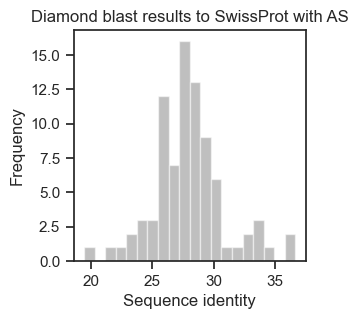

In [37]:
# Run this with BLAST residues
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(test_df, 'From', 'Residue', 'BLAST_residues', 'Sequence')

rows = []
rows.append(['BLAST', None, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])
u.dp(['BLAST', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])

plt.hist(df['sequence identity'].values, bins=20, color='grey', alpha=0.5)
plt.title('Diamond blast results to SwissProt with AS')
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
plt.savefig('figures/BLAST_identity_cataloDB.svg')

# Check the results for the 15B and the 3B models

Here we join them with the test_df and make sure that we get similar results!

In [51]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df


df = pd.read_csv('data/CataloDB_BLAST_blast_True.csv')
df.set_index('Entry', inplace=True)
squidly = pd.read_pickle('data/CataloDB_3B_squidly.pkl')
squidly.set_index('label', inplace=True)
df = df.join(squidly, how='left')

# Print out the predictions for the 3B
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'Residue', 'Squidly_CR_Position', 'Sequence')
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement
u.dp(['Squidly 3B', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])
rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'Residue', 'chosen_residues', 'Sequence')
    rows.append(['3B', squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Squidly 3B	
F1	0.5844748858447488	
precision:	0.7966804979253111	
 recall:	0.46153846153846156	
--------------------------------------------------------------------------------


  6%| | 3/50 [00:00<00:02, 20.

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0


 12%| | 6/50 [00:00<00:02, 20.

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0


 18%|▏| 9/50 [00:00<00:02, 20.

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------


 24%|▏| 12/50 [00:00<00:01, 20

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	136	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	135	             
--------------------------------------------------------------------------------
0


 36%|▎| 18/50 [00:00<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	132	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	133	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	132	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 42%|▍| 21/50 [00:01<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	132	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 54%|▌| 27/50 [00:01<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 66%|▋| 33/50 [00:01<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 72%|▋| 36/50 [00:01<00:00, 20

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0


 84%|▊| 42/50 [00:02<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 90%|▉| 45/50 [00:02<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

100%|█| 50/50 [00:02<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------


In [52]:
df = pd.read_csv('data/CataloDB_BLAST_blast_True.csv')
df.set_index('Entry', inplace=True)
squidly = pd.read_pickle('data/CataloDB_15B_squidly.pkl')
squidly.set_index('label', inplace=True)
df = df.join(squidly, how='left')

# Print out the predictions for the 3B
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'Residue', 'Squidly_CR_Position', 'Sequence')

u.dp(['Squidly 15B', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])

for squidly_cutoff in tqdm(range(0, 100, 2)):
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'Residue', 'chosen_residues', 'Sequence')
    rows.append(['15B', squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Squidly 15B	
F1	0.6077844311377246	
precision:	0.8055555555555556	
 recall:	0.4879807692307692	
--------------------------------------------------------------------------------


  6%| | 3/50 [00:00<00:02, 20.

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0


 12%| | 6/50 [00:00<00:02, 20.

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0


 18%|▏| 9/50 [00:00<00:02, 20.

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------


 24%|▏| 12/50 [00:00<00:01, 20

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	138	             
--------------------------------------------------------------------------------
0


 36%|▎| 18/50 [00:00<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	135	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	135	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	133	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	132	             
--------------------------------------------------------------------------------
0
--------------------

 42%|▍| 21/50 [00:01<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	132	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 54%|▌| 27/50 [00:01<00:01, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 60%|▌| 30/50 [00:01<00:00, 20

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0


 72%|▋| 36/50 [00:01<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 84%|▊| 42/50 [00:02<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

 90%|▉| 45/50 [00:02<00:00, 20

--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------

100%|█| 50/50 [00:02<00:00, 20

0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
            Total number:	232	Those with at least one overlap:	131	             
--------------------------------------------------------------------------------


# Finally look at the ensemble of the two datasets

Here we want to look at ensembling 

In [53]:
vis_df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
vis_df.to_csv('data/Ensemble_Squidly_CataloDB_15B.csv', index=False)

In [54]:
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

    

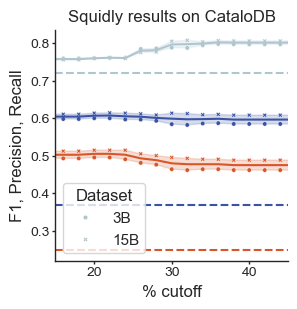

In [55]:
sns.color_palette(['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
plt.rcParams['svg.fonttype'] = 'none'

# BLAST	
# F1	0.368515205724508	
# precision:	0.7202797202797203	
#  recall:	0.24759615384615385

# Squidly 3B	
# F1	0.6060000000000001	
# precision:	0.5188356164383562	
#  recall:	0.7283653846153846

# Squidly 15B	
# F1	0.5987780040733198	
# precision:	0.519434628975265	
#  recall:	0.7067307692307693	

ax = sns.lineplot(vis_df, x='% cutoff', y='Recall', legend=None, color='#D7572B') #palette=['#D7572B', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
#ax.axvline(25, c='black', linestyle = 'dashed')
#ax.axvline(45, c='black', linestyle = 'dashed')

ax = sns.scatterplot(vis_df, x='% cutoff', y='Recall', style='Dataset', legend=None, markers=['o', 'X'], s=10, color='#D7572B') #palette=['#D7572B', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
ax.axhline(0.24759615384615385, c='#D7572B', linestyle = 'dashed') # Recall for BLAST
#ax.axhline(0.7283653846153846, c='#D7572B') # Squidly 3B Recall
ax = sns.lineplot(vis_df, x='% cutoff', y='F1', ax = ax, legend=None, color='#3A53A4') # Blue is F1
ax = sns.scatterplot(vis_df, x='% cutoff', y='F1', ax = ax,  style='Dataset', legend=None, markers=['o', 'X'], s=10, color='#3A53A4') # Blue is F1
ax.axhline(0.368515205724508, c='#3A53A4', linestyle = 'dashed') # Blast F1
#ax.axhline(0.6060000000000001, c='#3A53A4') # Squidly 3B F1
ax = sns.lineplot(vis_df, x='% cutoff', y='Precision', legend=None, color='#AFC6CF') # light blue is precision
ax = sns.scatterplot(vis_df, x='% cutoff', y='Precision',  style='Dataset',  s=10, color='#AFC6CF') # light blue is precision
ax.axhline(0.7202797202797203, c='#AFC6CF', linestyle='dashed') # BLAST Precision
#ax.axhline(0.5188356164383562, c='#AFC6CF') # Squidly Precision
# markers=['o', 'X'], o = 3B x = 15B
plt.xlim(0, 100)
plt.xlim(15, 45)
clean_plt(plt.gca())
plt.title('Squidly results on CataloDB')
plt.ylabel('F1, Precision, Recall')
plt.savefig('figures/Recall_3B-15B_BLAST.svg')
plt.show()